## NN Adv Assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [4]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values
X_test = test.values

### Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

### Device & HyperParameter Setting

In [6]:
DEVICE = torch.device('mps')
print(DEVICE)

mps


In [7]:
BATCH_SIZE = 128
EPOCHS = 100

### Dataset & DataLoader

In [204]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [9]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

### Train & Test function

In [92]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

### Model - BaseLine

In [16]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [17]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Training

In [18]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.5272, 	Train Accuracy: 80.84 %, 	Val Loss: 0.4590, 	Val Accuracy: 81.75 % 

[EPOCH: 2], 	Train Loss: 0.4099, 	Train Accuracy: 85.18 %, 	Val Loss: 0.3460, 	Val Accuracy: 86.99 % 

[EPOCH: 3], 	Train Loss: 0.3744, 	Train Accuracy: 86.37 %, 	Val Loss: 0.3363, 	Val Accuracy: 87.76 % 

[EPOCH: 4], 	Train Loss: 0.3481, 	Train Accuracy: 87.22 %, 	Val Loss: 0.3116, 	Val Accuracy: 88.59 % 

[EPOCH: 5], 	Train Loss: 0.3257, 	Train Accuracy: 87.95 %, 	Val Loss: 0.3250, 	Val Accuracy: 87.65 % 

[EPOCH: 6], 	Train Loss: 0.3122, 	Train Accuracy: 88.38 %, 	Val Loss: 0.3122, 	Val Accuracy: 88.61 % 

[EPOCH: 7], 	Train Loss: 0.2964, 	Train Accuracy: 89.13 %, 	Val Loss: 0.3157, 	Val Accuracy: 88.55 % 

[EPOCH: 8], 	Train Loss: 0.2842, 	Train Accuracy: 89.37 %, 	Val Loss: 0.3105, 	Val Accuracy: 88.79 % 

[EPOCH: 9], 	Train Loss: 0.2701, 	Train Accuracy: 89.92 %, 	Val Loss: 0.2914, 	Val Accuracy: 89.66 % 

[EPOCH: 10], 	Train Loss: 0.2653, 	Train Accuracy: 90.10 %, 	Val Loss: 0.

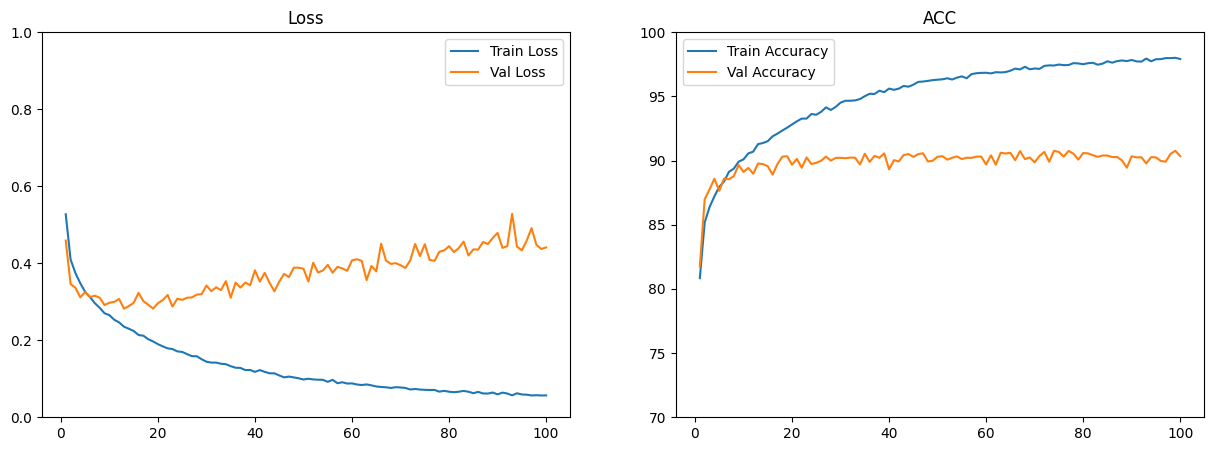

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(70, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

# CNN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

In [257]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

In [258]:
DEVICE = torch.device("mps")
BATCH_SIZE = 128
EPOCHS = 50

In [259]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

class FashionDataset(Dataset):
        
    def __init__(self, image, label, transform = None):
        self.transform = transform
        self.labels =label
        self.images = image.reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)
  
  

In [260]:
train_dataset = FashionDataset(X_train, y_train, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last=False)

val_dataset = FashionDataset(X_val, y_val,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last=False)

In [261]:
images, labels = next(iter(train_loader))
images.shape

torch.Size([128, 1, 28, 28])

In [262]:
def train_CNN(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate_CNN(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

In [263]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def _init_weight_(self):
        for m in self.linear1:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

        for m in self.linear2:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

        for m in self.linear3:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)        
                
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [264]:
model = FashionCNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [265]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train_CNN(model, train_loader)
  val_loss, val_accuracy = evaluate_CNN(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.4637, 	Train Accuracy: 83.64 %, 	Val Loss: 0.3264, 	Val Accuracy: 88.80 % 

[EPOCH: 2], 	Train Loss: 0.3146, 	Train Accuracy: 88.66 %, 	Val Loss: 0.2888, 	Val Accuracy: 89.65 % 

[EPOCH: 3], 	Train Loss: 0.2750, 	Train Accuracy: 89.95 %, 	Val Loss: 0.3002, 	Val Accuracy: 89.33 % 

[EPOCH: 4], 	Train Loss: 0.2484, 	Train Accuracy: 90.98 %, 	Val Loss: 0.2578, 	Val Accuracy: 91.17 % 

[EPOCH: 5], 	Train Loss: 0.2315, 	Train Accuracy: 91.51 %, 	Val Loss: 0.2724, 	Val Accuracy: 90.59 % 

[EPOCH: 6], 	Train Loss: 0.2130, 	Train Accuracy: 92.34 %, 	Val Loss: 0.3010, 	Val Accuracy: 89.81 % 

[EPOCH: 7], 	Train Loss: 0.1945, 	Train Accuracy: 92.89 %, 	Val Loss: 0.2374, 	Val Accuracy: 91.82 % 

[EPOCH: 8], 	Train Loss: 0.1836, 	Train Accuracy: 93.30 %, 	Val Loss: 0.2527, 	Val Accuracy: 91.46 % 

[EPOCH: 9], 	Train Loss: 0.1720, 	Train Accuracy: 93.75 %, 	Val Loss: 0.2736, 	Val Accuracy: 90.85 % 

[EPOCH: 10], 	Train Loss: 0.1573, 	Train Accuracy: 94.26 %, 	Val Loss: 0.

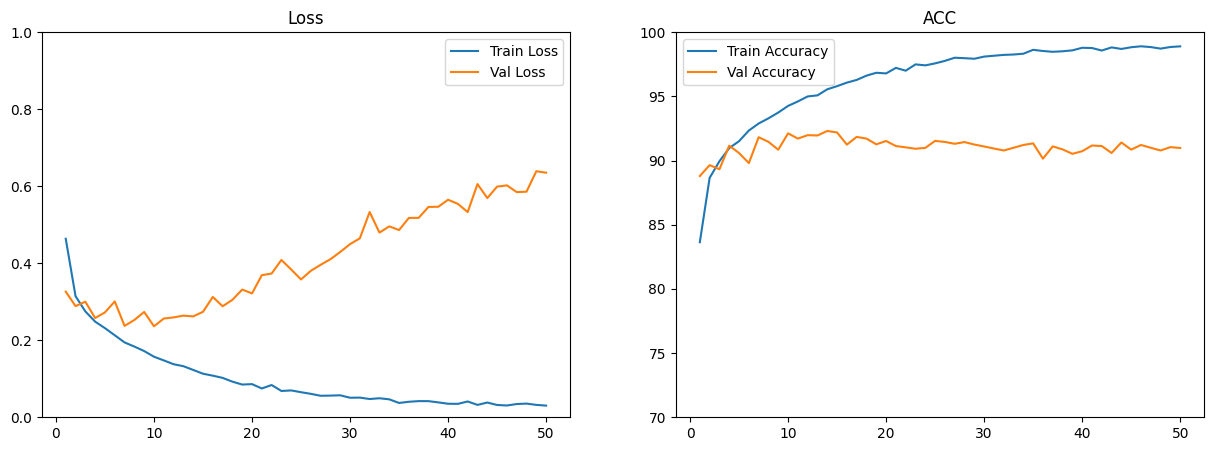

In [266]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(70, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()